In [ ]:
# hide
from nbdev.showdoc import show_doc

# Glass Identification
> In this example, we will use a standard imbalanced machine learning dataset referred to as the “Glass Identification” dataset.

The dataset describes the chemical properties of glass and involves classifying samples of glass using their chemical properties as one of seven classes. There are nine input variables that summarize the properties
- **RI:** refractive index
- **Na:** Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)
- **Mg:** Magnesium
- **Al:** Aluminum
- **Si:** Silicon
- **K:** Potassium
- **Ca:** Calcium
- **Ba:** Barium
- **Fe:** Iron

The chemical compositions are measured as the weight percent in corresponding oxide. There are seven types of glass listed (class attribute)
- **1:** building_windows_float_processed
- **2:** building_windows_non_float_processed
- **3:** vehicle_windows_float_processed
- **4:** vehicle_windows_non_float_processed (none in this database)
- **5:** containers
- **6:** tableware
- **7:** headlamps

## Setup

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import (
    LeaveOneOut,
    RepeatedStratifiedKFold,
    cross_val_score,
)

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier

from res.utils import find_project_root
from res.datasets import get_glass
from res.metrics import accuracy

## Define Variables

In [ ]:
PROJECT_ROOT = find_project_root()
USE_LOCAL_DATA = False
SEED: int = 42
DATA_SOURCE_DIRECTORY: str = "data/glass"
MODEL_TEST_SIZE: float = 0.2
MODEL_LEARNING_RATE: float = 0.001
MODEL_EPOCHS: int = 10
MODEL_BATCH_SIZE: int = 120

## Load Dataset

In [ ]:
X, y = get_glass(USE_LOCAL_DATA)

## Prepare data

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# linear scaling of real-valued inputs to complex-valued inputs (on unit circle)
def transform(data, alpha=2 * np.pi):
    for feature in range(data.shape[1]):
        a = np.min(data[:, feature])
        b = np.max(data[:, feature])
        data[:, feature] = ((data[:, feature] - a) / (b - a)) * alpha
        # ((1.52101 - a) / ( b - a )) * ((2 * np.pi) - (np.pi /8)  ) ????
    # data = np.round(data, 3)
    # return np.exp(1.j * np.remainder(data, 2*np.pi))
    return np.exp(1.0j * data)


def transform_unitCircle(data):
    return np.exp(1.0j * np.remainder(data, 2 * np.pi))


if USE_LOCAL_DATA:
    X_scaled = transform(X, alpha=2 * np.pi - np.pi / 8)
else:
    X_scaled = transform_unitCircle(X)

In [ ]:
# one-hot-encoding for MVN
numSamples, numFeatures = X.shape
y2 = y + 1  # auxiliary variable so that classes start at 1 and not 0
neuronCats = 6  # parameter that determines the number of output neurons
no = int(np.ceil(max(y2) / neuronCats))  # number of output neurons
if no != 1:
    y = torch.zeros(numSamples, no)
    for i in range(numSamples):
        k = int(np.ceil(y2[i] / neuronCats)) - 1
        c = np.mod((y2[i] - 1), neuronCats) + 1
        y[i, k] = c

### EDA

#### Feature Distributions

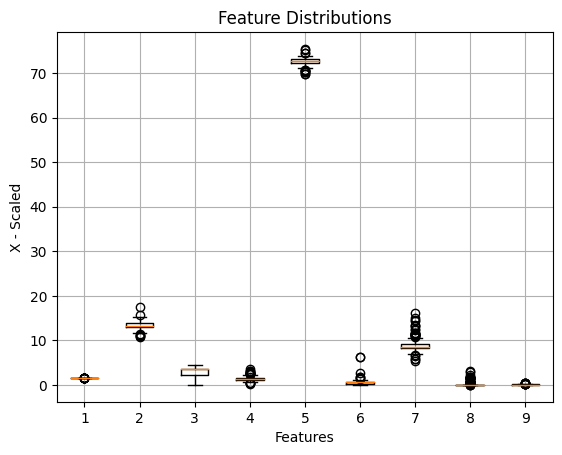

In [ ]:
# hide_input
plt.boxplot(X)
plt.xlabel("Features")
plt.ylabel("X - Scaled")
plt.title("Feature Distributions")
plt.grid()
plt.show()

#### Class Distributions

In [ ]:
# hide_input
from collections import Counter

counter = Counter(y)
for k, v in counter.items():
    per = v / len(y) * 100
    print("Class =%2d, Count =%3d, Percentage = %.3f%%" % (k, v, per))

Class = 5, Count = 29, Percentage = 13.551%
Class = 0, Count = 70, Percentage = 32.710%
Class = 1, Count = 76, Percentage = 35.514%
Class = 4, Count =  9, Percentage = 4.206%
Class = 3, Count = 13, Percentage = 6.075%
Class = 2, Count = 17, Percentage = 7.944%



## Support Vector Machine (SVM), k-Nearest Neighbors (KNN), Bagged Decision Trees (BAG), Random Forest (RF), Extra Trees (ET)

In [ ]:
# hide_input

# evaluate a model
def evaluate_model(X, y, model, cv):
    # evaluate model
    scores = cross_val_score(model, X, y, scoring="accuracy", cv=cv, n_jobs=-1)
    return scores


# define models to test
def get_models():
    models, names = list(), list()
    # SVM
    models.append(SVC(gamma="auto"))
    names.append("SVM")
    # KNN
    models.append(KNeighborsClassifier())
    names.append("KNN")
    # # Bagging
    models.append(BaggingClassifier(n_estimators=1000))
    names.append("BAG")
    # RF
    models.append(RandomForestClassifier(n_estimators=1000))
    names.append("RF")
    # # ET
    models.append(ExtraTreesClassifier(n_estimators=1000))
    names.append("ET")
    return models, names

## Stratified k-Fold Cross-Validation

In [ ]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

In [ ]:
# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
    # evaluate the model and store results
    scores = evaluate_model(X, y.ravel(), models[i], rskf)
    results.append(scores)
    # summarize performance
    print(">%s %.3f (%.3f)" % (names[i], mean(scores), std(scores)))

>SVM 0.662 (0.055)
>KNN 0.662 (0.080)
>BAG 0.755 (0.061)
>RF 0.796 (0.058)
>ET 0.793 (0.041)


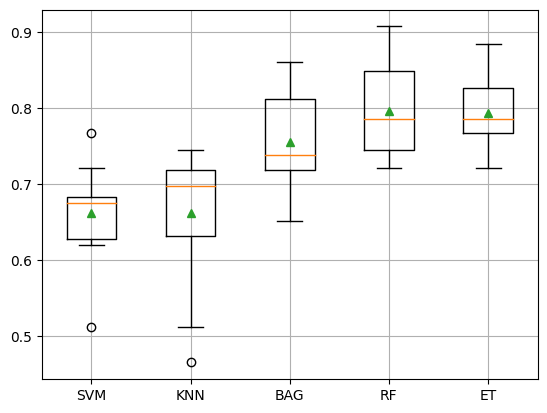

In [ ]:
# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.grid()
plt.show()

### Models

In [ ]:
# hide
# Add mlmvn results
names.append("MLMVN")
results.append(scores_test)

#### MLMVN

In [ ]:
# hide
ns, ni = X.shape

# Training loop
epochs = 100  # how many epochs to train for
bs = 300  # batch size
loss_vals = []
acc_vals = []

scores_train = []
scores_test = []
classif_ratesum = 0

loo = LeaveOneOut()
loo.get_n_splits(X)

# log_param("epochs", epo
# chs)
# log_param("batch size", bs)

214

In [ ]:
# hide
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

scores_train = []
scores_test = []

for train_index, test_index in rskf.split(X_scaled, y):
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Convert numpy arrays into torch tensors
    X_train_t, y_train_t, X_test_t, y_test_t = map(
        torch.tensor, (X_train, y_train, X_test, y_test)
    )

    # MVN
    net = NeuralNet(
        [
            FirstHiddenLayer(input_size=ni, output_size=50),
            CmplxActivation(),
            # HiddenLayer(input_size = 50, output_size = 36),
            # CmplxActivation(),
            OutputLayer(input_size=50, output_size=no),
            CmplxActivation(),
        ]
    )

    # Define loss and optimizer
    loss: Loss = RMSE(categories=6, periodicity=1)
    optimizer: Optimizer = ECL()

    for epoch in range(epochs):
        epoch_loss = []
        epoch_acc = []
        for i in range((ns - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = X_train_t[start_i:end_i]
            yb = y_train_t[start_i:end_i]

            predicted = net.forward(xb)
            angle = loss.angle(predicted, yb)  # delta calculation for the output layer
            net.backward(angle)  # delta calculation for further layers
            with torch.no_grad():
                optimizer.step(net, bs)

            epoch_loss.append(loss.loss_angles(predicted, yb))

            if epoch % 25 == 0:
                print(f"Epoch: {epoch:>5d} -------------- |")
                print(f"loss: {epoch_loss[-1]:>.5f}  [{start_i}/{len(X_train_t)}]")
        loss_vals.append(sum(epoch_loss) / len(epoch_loss))

    predictions = torch.randn(y_train_t.shape, dtype=torch.double)
    for x, i in zip(X_train_t, range(len(y_train_t))):
        predicted = net.forward(x)
        predictions[i] = loss.angle2class(predicted)

    acc = accuracy(predictions, y_train_t)
    scores_train.append(acc)
    print("Train Accuracy: ", acc)

    predictions = torch.randn(y_test_t.shape, dtype=torch.double)
    for x, y_t, i in zip(X_test_t, y_test_t, range(len(y_test_t))):
        predicted = net.forward(x)
        predictions[i] = loss.angle2class(predicted)

    acc = accuracy(predictions, y_test_t)
    scores_test.append(acc)
    print("Test Accuracy: ", acc)

# log_metric(key="Mean Train Accuracy", value=np.mean(scores_train))
# log_metric(key="Mean Test Accuracy", value=np.mean(scores_test))

Epoch:     0 -------------- |
loss: 4.11741  [0/171]
Epoch:    25 -------------- |
loss: 0.42983  [0/171]
Epoch:    50 -------------- |
loss: 0.36630  [0/171]
Epoch:    75 -------------- |
loss: 0.28856  [0/171]
Train Accuracy:  0.8304093567251462
Test Accuracy:  0.46511627906976744
Epoch:     0 -------------- |
loss: 2.38649  [0/171]
Epoch:    25 -------------- |
loss: 0.48131  [0/171]
Epoch:    50 -------------- |
loss: 0.26562  [0/171]
Epoch:    75 -------------- |
loss: 0.27163  [0/171]
Train Accuracy:  0.8538011695906432
Test Accuracy:  0.5116279069767442
Epoch:     0 -------------- |
loss: 1.47664  [0/171]
Epoch:    25 -------------- |
loss: 0.29869  [0/171]
Epoch:    50 -------------- |
loss: 0.29174  [0/171]
Epoch:    75 -------------- |
loss: 0.20116  [0/171]
Train Accuracy:  0.8128654970760234
Test Accuracy:  0.627906976744186
Epoch:     0 -------------- |
loss: 3.74723  [0/171]
Epoch:    25 -------------- |
loss: 0.34983  [0/171]
Epoch:    50 -------------- |
loss: 0.28350  

In [ ]:
# hide_input
print("Train: %.3f (%.3f)" % (np.mean(scores_train), np.std(scores_train)))
print("Test: %.3f (%.3f)" % (np.mean(scores_test), np.std(scores_test)))

Train: 0.838 (0.018)
Test: 0.570 (0.096)


### Results

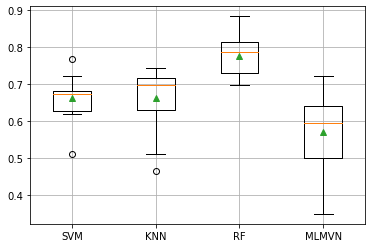

In [ ]:
# hide_input
# plot the results
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.grid()
pyplot.show()

## Leave One-Out Cross-Validation 

### Models

#### MLMVN

In [ ]:
ns, ni = X.shape

# Training loop
epochs = 1000  # how many epochs to train for
bs = 300  # batch size
loss_vals = []
acc_vals = []

scores_train = []
scores_test = []
classif_ratesum = 0

loo = LeaveOneOut()
loo.get_n_splits(X)

log_param("epochs", epochs)
log_param("batch size", bs)

In [ ]:
for train_index, test_index in loo.split(X_scaled):
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Convert numpy arrays into torch tensors
    X_train, y_train, X_test, y_test = map(
        torch.tensor, (X_train, y_train, X_test, y_test)
    )

    # mlmvn
    model = NeuralNet(
        [
            FirstHiddenLayer(input_size=ni, output_size=36),
            CmplxActivation(),
            # HiddenLayer(input_size = 36, output_size = 2),
            # CmplxActivation(),
            OutputLayer(input_size=36, output_size=no),
            CmplxActivation(),
        ]
    )
    # model.load('mlmvn_debug_matlab_weights')

    # Define loss and optimizer
    loss: Loss = RMSE(categories=6, periodicity=1)
    optimizer: Optimizer = ECL()

    for epoch in range(epochs):
        epoch_loss = []
        epoch_acc = []
        # print(f"Epoch: {epoch:>5d} -------------- |")
        for i in range((ns - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = X_train[start_i:end_i]
            yb = y_train[start_i:end_i]

            predicted = model.forward(xb)
            angle = loss.angle(predicted, yb)  # delta calculation for the output layer
            model.backward(angle)  # delta calculation for further layers
            with torch.no_grad():
                optimizer.step(model, xb.size(0))  # bs

            epoch_loss.append(loss.loss_angles(predicted, yb))
            # if i % 100 == 0:
            #     print(f"loss: {epoch_loss[-1]:>.5f}  [{start_i}/{len(X_train)}]")
        loss_vals.append(sum(epoch_loss) / len(epoch_loss))
        log_metric(key="Epoch loss", value=loss_vals[-1], step=epoch)

    print(f"Leave one out at index {test_index[0]:>5d} -------------- |")

    predictions = torch.randn(y_train.shape, dtype=torch.double)
    for x, i in zip(X_train, range(len(y_train))):
        predicted = model.forward(x)
        predictions[i] = loss.angle2class(predicted)
        # valid_loss = loss.loss(predicted, y_t)

    acc = accuracy(predictions, y_train)
    scores_train.append(acc)
    log_metric(key="Train Accuracy", value=acc, step=epoch)
    print("Train Accuracy: ", acc)

    predictions = torch.randn(y_test.shape, dtype=torch.double)
    for x, y_t, i in zip(X_test, y_test, range(len(y_test))):
        predicted = model.forward(x)
        predictions[i] = loss.angle2class(predicted)
        # valid_loss = loss.loss(predicted, y_t)

    acc = accuracy(predictions, y_test)
    scores_test.append(acc)
    print("Test Accuracy: ", acc)

In [ ]:
log_metric(key="Mean Train Accuracy", value=np.mean(scores_train))
log_metric(key="Mean Test Accuracy", value=np.mean(scores_test))
print("Train: %.3f (%.3f)" % (np.mean(scores_train), np.std(scores_train)))
print("Test: %.3f (%.3f)" % (np.mean(scores_test), np.std(scores_test)))
print("\Glass test end ...")